# Flight Data Recorder
<img src="media/fdr.jpg" width="300px" height="auto">

The flight data recorder is a microcontroller based system that uses a multitude of sensors to capture in-flight performance data. This includes GPS, altitude, heading, pitch, roll, angular acceleration, linear acceleration, temperature, and wind speed. The sensors are sampled at 100 Hz and written onto a microSD card in CSV format. The data recorder is removed after landing (or crash), and the data is retreived. In the case of a crash, the data visualizations can help piece together what went wrong, much like a real black box. Important metrics such as altitude and ground speed can simply be measured from the data. We can also apply descriptive analytics, to visualize patterns and correlations. This information can then be used by the team to help make design decisions and improve plane performance.

There are three useful notebooks: `flight_report.ipynb`, `data_analysis.ipynb`, and `demo.ipynb`. The `flight_report.ipynb` notebook is designed to quickly generate interactive flight reports from input data. Use this notebook if you just want to look at the reports. `data_analysis.ipynb` is better for understanding the code, as it is better documented and split into more digestable pieces. The last notebook, `demo.ipynb`, is more of a playground to get a feel for some useful python packages.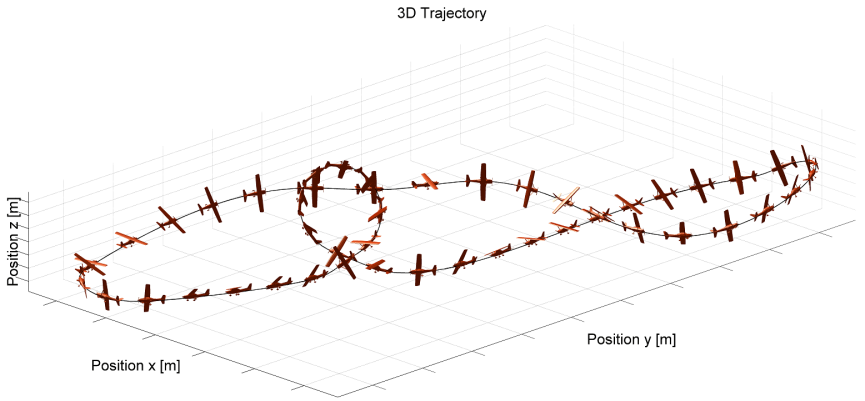

## Data Input and Processing

In [1]:
import pandas as pd
from math import pi,sqrt,sin,cos,acos,asin,atan2,radians,degrees

## Modify sensor_files, fdr_files to match the files you would like to be processed. 
## Make sure the order of files correspond to matching tests
sensor_files = ['sensor_1.TXT', 'sensor_2.TXT', 'sensor_3.TXT','sensor_4.TXT','sensor_5.TXT','sensor_6.TXT']
fdr_files = ['fdr_1.TXT', 'fdr_2.TXT', 'fdr_3.TXT', 'fdr_4.TXT', 'fdr_5.TXT', 'fdr_6.TXT']
# Use relative path (you shouldn't need to change this)
path = 'inputData(1-5-21)/'

# the following specifies the order of data coming in a line of the CSV file; do not modify
# Count, System Calibration level (0-3), Linear Acceleration XYZ (m/s^2), Gyro XYZ (radians/sec), Quaternion WXYZ
sensor_header = ['count', 'sr_sys', 'sr_x_accel', 'sr_y_accel', 'sr_z_accel', 'sr_x_rps','sr_y_rps', 'sr_z_rps', 
                 'sr_qw', 'sr_qx', 'sr_qy', 'sr_qz']

# the FDR collects the same info as the sensor, plus GPS data appended on the end in NMEA GPGGA sentences
fdr_header = ['count', 'fr_sys', 'fr_x_accel', 'fr_y_accel', 'fr_z_accel', 'fr_x_rps', 'fr_y_rps', 'fr_z_rps', 'fr_qw', 
              'fr_qx', 'fr_qy', 'fr_qz', 'gps', 'UTC', 'lat', 'NS', 'long', 'EW', 'fix', 'sats', 'HDOP', 'elev', 'units1', 
              'geoid', 'units2', 'age', 'checksum']

# df_list stores each flight test as a dataframe
df_list = []

# puts the csv into dataframes with a header
for i in range(len(sensor_files)):
    # add sensor file
    filepath = path + sensor_files[i]
    df_sr = pd.read_csv(filepath, sep=",", header=None)
    # add header
    df_sr.columns = sensor_header
    # add fdr file
    filepath = path + fdr_files[i]
    df_fr = pd.read_csv(filepath, sep=",", header=None)
    # add header
    df_fr.columns = fdr_header
    # merge dataframes sensor + fdr
    df = pd.merge(df_sr, df_fr, how='left',on='count')
    df_list.append(df)

### Function Definitions: ###

### Cleaning Functions: ###


## removes uncalibrated rows from dataframe
def remove_rows(df):
    #rows = df[(df['sr_sys'] == 0) | (df['fr_sys'] == 0)].index
    #drop rows if sensor calibration level is 0
    rows = df[df['sr_sys'] == 0].index
    df.drop(rows, inplace=True)

### Conversion Functions: ###


## remove unused columns from dataframe
def remove_cols(df):
    df.drop(['gps','UTC','NS', 'EW','HDOP','units1', 'geoid', 'units2', 'age', 'checksum'], axis='columns', inplace=True)

## converts float from degree-minute-second to degree, latitude conversion
def dd_lat(x):
    degrees = int(x) // 100
    minutes = x - 100*degrees
    return degrees + minutes/60

## converts float from degree-minute-second to degree, longitude conversion
def dd_lon(x):
    return -dd_lat(x)


### Calculation Functions: ###

# Input row of dataframe
# returns bearing from prev row's to row's GPS coords
# https://stackoverflow.com/questions/54873868/python-calculate-bearing-between-two-lat-long
def get_bearing(row):
    lat1 = row['prev_lat']
    long1 = row['prev_long']
    lat2 = row['lat']
    long2 = row['long']
    dLon = (long2 - long1)
    x = cos(radians(lat2)) * sin(radians(dLon))
    y = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(radians(dLon))
    bearing = atan2(x,y)
    return bearing

# input a row from dataframe
# returns the distance between prev coords to row's coords
# more precisely, it calculates the distance between two points on a sphere (ie. the earth)
# https://stackoverflow.com/questions/365826/calculate-distance-between-2-gps-coordinates
def haversine(row):
    lat1 = row['prev_lat']
    long1 = row['prev_long']
    lat2 = row['lat']
    long2 = row['long']                                                          
    degree_to_rad = float(pi / 180.0)
    d_lat = (lat2 - lat1) * degree_to_rad
    d_long = (long2 - long1) * degree_to_rad
    a = pow(sin(d_lat / 2), 2) + cos(lat1 * degree_to_rad) * cos(lat2 * degree_to_rad) * pow(sin(d_long / 2), 2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    mi = 3956 * c
    return mi

# input a row from dataframe
# returns the speed using distance/time
def speed(row):
    millis = row['count'] - row['prev_count']
    hours = millis / 36000
    return row['delta'] / hours

### Clean data, Add some columns for calculations, Clean again ###

for i in range(len(df_list)):
    remove_rows(df_list[i])
    remove_cols(df_list[i])
    # remove all rows with NaN values
    df_list[i].dropna(inplace=True)
    # apply latitude and longitude conversions to all rows
    df_list[i]['lat'] = df_list[i]['lat'].apply(dd_lat)
    df_list[i]['long'] = df_list[i]['long'].apply(dd_lon)
    # add prev_lat, prev_long, prev_count columns
    df_list[i]['prev_lat'] = df_list[i]['lat'].shift(1)
    df_list[i]['prev_long'] = df_list[i]['long'].shift(1)
    df_list[i]['prev_count'] = df_list[i]['count'].shift(1)
    # deletes first row
    df_list[i].dropna(inplace=True)
    # add a instantaneous bearing based off prev GPS coord
    df_list[i]['bearing'] = df_list[i].apply(lambda row: get_bearing(row), axis=1)
    # delta distance
    df_list[i]['delta'] = df_list[i].apply(lambda row: haversine(row), axis=1)
    # add mph column
    df_list[i]['mph'] = df_list[i].apply(lambda row: speed(row), axis=1)
    # remove temp. columns
    df_list[i].drop(columns=['delta', 'prev_lat', 'prev_long', 'prev_count'], inplace=True)

    
### Quaternion Definitions ###
### Define some Quarternion and Euler Math ###

# https://www.meccanismocomplesso.org/en/hamiltons-quaternions-and-3d-rotation-with-python/
def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def euler_to_quaternion(phi, theta, psi):
    qw = cos(phi/2) * cos(theta/2) * cos(psi/2) + sin(phi/2) * sin(theta/2) * sin(psi/2)
    qx = sin(phi/2) * cos(theta/2) * cos(psi/2) - cos(phi/2) * sin(theta/2) * sin(psi/2)
    qy = cos(phi/2) * sin(theta/2) * cos(psi/2) + sin(phi/2) * cos(theta/2) * sin(psi/2)
    qz = cos(phi/2) * cos(theta/2) * sin(psi/2) - sin(phi/2) * sin(theta/2) * cos(psi/2)
    return [qw, qx, qy, qz]

def quaternion_to_euler(w, x, y, z):
    t0 = 2 * (w * x + y * z)
    t1 = 1 - 2 * (x * x + y * y)
    X = atan2(t0, t1)
    t2 = 2 * (w * y - z * x)
    t2 = 1 if t2 > 1 else t2
    t2 = -1 if t2 < -1 else t2
    Y = asin(t2)
    t3 = 2 * (w * z + x * y)
    t4 = 1 - 2 * (y * y + z * z)
    Z = atan2(t3, t4)
    return X, Y, Z


# Time For Visualization!

Generate the flight report with multiple subplots. Interactive, save as pdf.

In [2]:
# setup some parameters
f = 1
mph_min = 0
mph_max = 60
mph_init = 30
save_report_as_png = True
png_name = 'test.png'

# look & feel
figsize = (10,8)
dotsize = 10
rows = 2
cols = 2
samples = 1
scale = 15

In [3]:
%matplotlib widget
from matplotlib.path import Path
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
# uses map tiles from Open Street Map
from cartopy.io.img_tiles import OSM
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D, proj3d
import matplotlib.animation

fig = plt.figure(figsize=figsize)#, constrained_layout=True)

dff = df_list[f][(df_list[f]['mph'] > mph_init)][::samples]

# add a 0 mph lower bound
extra=dff.tail(1)
dff.append(extra)
dff.iloc[len(dff)-1, df.columns.get_loc('mph')] = 0

##################################################################### Map ############################################################################

# set plot window coordinates (1: bottom left 2: top right)
padding = 0.002
lat1 = df_list[f]['lat'].min() - padding
lon1 = df_list[f]['long'].min() - padding
lat2 = df_list[f]['lat'].max() + padding
lon2 = df_list[f]['long'].max() + padding

imagery = OSM()
ax = fig.add_subplot(rows,cols,1,projection=imagery.crs)
ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())

## Modify scale (15) to zoom in and out of the map (also increase/decreases pixelation)
ax.add_image(imagery, scale)

# plot gps coords
scat = ax.scatter(dff['long'], dff['lat'],c=dff['mph'], cmap='autumn',s=dotsize,alpha=1,transform=ccrs.PlateCarree())

# plot start and stop coords with special symbols
start = ax.scatter(dff['long'].head(1), dff['lat'].head(1),marker=">",color='green',edgecolors='black',linewidths=1,s=dotsize,alpha=1,transform=ccrs.PlateCarree())
stop = ax.scatter(dff['long'].tail(1), dff['lat'].tail(1),marker="s",color='red',edgecolors='black',linewidths=1,s=dotsize,alpha=1,transform=ccrs.PlateCarree())

# add a colorbar
# https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.2, axes_class=plt.Axes)
fig.add_axes(ax_cb)
plt.colorbar(scat,cax=ax_cb,label='mph')
ax.set_title('Map of Flight ' + str(f))
######################################################### 3d flight path #############################################################################
### Now Lets plot the datapoints in 3D ###

ax = fig.add_subplot(rows,cols,2,projection='3d')
ax.axes.set_xlim3d(left=dff['long'].min(), right=dff['long'].max()) 
ax.axes.set_ylim3d(bottom=dff['lat'].min(), top=dff['lat'].max()) 
ax.axes.set_zlim3d(bottom=0, top=dff['elev'].max()) 
ax.axes.set_xlabel('Longitude')
ax.axes.set_ylabel('Latitude')
ax.axes.set_zlabel('Elevation')
ax.axes.set(xticklabels=[],yticklabels=[])

scat3d = ax.scatter(dff['long'], dff['lat'], dff['elev'],s=dotsize,c=dff['mph'],cmap='autumn',depthshade=True) 
ax.set_title('3d path of Flight ' + str(f))


############################################################ Sensor Plot #############################################################################
radius = 1
# define constant sqrt 2 over 2
srtot = sqrt(2)/2

# add subplot with nrows, ncols, index
ax = fig.add_subplot(rows,cols,3, projection='3d')
# define axis scale & labels
ax.axes.set_xlim3d(left=radius, right=0) 
ax.axes.set_ylim3d(bottom=srtot*radius, top=-srtot*radius) # flip y axis for sensor
ax.axes.set_zlim3d(bottom=-radius, top=0) 
ax.axes.set_xlabel('x')
ax.axes.set_ylabel('y')
ax.axes.set_zlabel('z')
ax.axes.set(xticklabels=[],yticklabels=[],zticklabels=[])

# Set equal unit aspect ratio
ax.set_box_aspect((radius, sqrt(2)*radius, radius))

# Make surface data
u = np.linspace(0, 0.5*np.pi, 15)
v = np.linspace(0.25*np.pi, 0.75*np.pi, 15)
x = radius * np.outer(np.cos(u), np.sin(v))
z = -radius * np.outer(np.sin(u), np.sin(v))
y = radius * np.outer(np.ones(np.size(u)), np.cos(v))


# set dotted line colors
lc="grey"
# horizontal 3 arrows
ax.quiver(0, 0, 0, radius, 0, 0, color=lc,ls='dashed',arrow_length_ratio=0)
ax.quiver(0, 0, 0, srtot*radius, srtot*radius, 0, color=lc,ls='dashed',arrow_length_ratio=0)
ax.quiver(0, 0, 0, srtot*radius, -srtot*radius, 0, color=lc,ls='dashed',arrow_length_ratio=0)

# vertical 3 arrows
ax.quiver(0, 0, 0, 0, 0, -radius, color=lc,ls='dashed',arrow_length_ratio=0)
ax.quiver(0, 0, 0, 0, srtot*radius, -srtot*radius, color=lc,ls='dashed',arrow_length_ratio=0)
ax.quiver(0, 0, 0, 0, -srtot*radius, -srtot*radius, color=lc,ls='dashed',arrow_length_ratio=0)

def adj_heading(row, v):
    sw = row['sr_qw']
    sx = row['sr_qx']
    sy = row['sr_qy']
    sz = row['sr_qz']
    # args: roll, pitch, yaw: 90 deg CCW for sensor reorientation
    q = euler_to_quaternion(0, 0, pi/2)
    q1 = (sw,sx,sy,sz) # <---- This raw sensor input
    q2 = q_mult(q,q1) # <---- rotate 90 deg CCW
    # now take GPS bearing and get it in quaternion
    q3 = euler_to_quaternion(0, 0, row['bearing'])
    q4 = q_mult(q3,q2)
    v = qv_mult(q4, v)
    return v

v1 = (1,0,0)
dff['v2'] = dff.apply(lambda row: adj_heading(row,v1), axis=1)
dff['v2x'] = dff['v2'].str[0]
dff['v2y'] = dff['v2'].str[1]
dff['v2z'] = dff['v2'].str[2]
vx = dff['v2x'].to_numpy()
vy = dff['v2y'].to_numpy()
vz = dff['v2z'].to_numpy()
sensor = ax.scatter(vx,vy,vz,c=dff['mph'], cmap='autumn',s=dotsize,depthshade=True)

def norm_avg(x,y,z):
    avgx = np.average(x)
    avgy = np.average(y)
    avgz = np.average(z)
    # returns vector with magnitude 1
    norm = sqrt(avgx**2 + avgy**2 + avgz**2)
    norm = 1/norm
    return avgx*norm, avgy*norm, avgz*norm
    

# avg sensor arrow

avgx,avgy,avgz = norm_avg(vx,vy,vz)
arrow = ax.quiver(0, 0, 0, avgx, avgy, avgz, color='black',ls='solid',lw = 2,arrow_length_ratio=0.1)


# assign colors based on mph 
# https://github.com/matplotlib/matplotlib/issues/3382
C = dff['mph'].to_numpy()
C = C/dff['mph'].max()
cmap = plt.get_cmap()


# Plot the surface
ax.plot_surface(x, y, z, color='grey',alpha=0.2)
ax.plot_wireframe(x, y, z, color='grey',alpha=0.3, lw = 1)
# Plot a dot
ax.scatter([0], [0], [0], color="b", s=25)
ax.set_title('Sensor Scatter Plot Flight ' + str(f))
temp = ax
############################################################# Stats ##################################################################################
dff['xang'] = dff.apply(lambda row: degrees(acos(row['v2x'])) , axis=1) 
dff['yang'] = dff.apply(lambda row: degrees(acos(row['v2y'])) , axis=1) 


def generate_txt(slider,count,elev,center,vsd,hsd):
    deg = u'\N{DEGREE SIGN}'
    line1 = "Data points over {slider} mph = {count}".format(slider=str(round(slider,0)), count=str(count))
    line2 = "\nAvg. angle from vertical = {angle}".format(angle=str(round(90-elev,2))) + deg
    line3 = "\nAvg. angle from center = {angle}".format(angle=str(round(center,2))) + deg
    line4 = "\nVertical Std. Dev. = {angle}".format(angle=str(round(vsd,2))) + deg
    line5 = "\nHorizontal Std. Dev. = {angle}".format(angle=str(round(hsd,2))) + deg
    txt = line1 + line2 + line3 + line4 + line5
    return txt
txt = generate_txt(mph_init,len(dff),degrees(acos(avgx)),-degrees(asin(avgy)),np.std(dff['xang']),np.std(dff['yang']))
title = "Sensor Stats Flight {num}:".format(num=f)

ax = fig.add_subplot(rows,cols,4)
ax.axis('off')
left, width = 0, 0
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.5*(left+right), 0.5*(2*top), title, horizontalalignment='left', verticalalignment='center', fontsize=16, transform=ax.transAxes)
stats = ax.text(0.5*(left+right), 0.5*(bottom+top), txt, horizontalalignment='left', verticalalignment='center', fontsize=12, transform=ax.transAxes)
# restore previous ax, so arrow is updated properly
ax = temp
######################################################################################################################################################
# https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
#https://stackoverflow.com/questions/41602588/matplotlib-3d-scatter-animations
# http://www.math.buffalo.edu/~badzioch/MTH337/PT/PT-matplotlib_slider/PT-matplotlib_slider.html
# Defining the Slider button
# xposition, yposition, width and height
mph_ax = plt.axes([0.25, 0.01, 0.65, 0.03])

# here we create the slider
mph_slider = Slider(mph_ax,'Filter Minimum MPH', mph_min, mph_max, valinit=mph_init)

def zero_out(row, mph, string):
    if (row['mph'] < mph):
        return 0;
    return row[str(string)]
    

def update(x):    
    ### update mph and filter data ###
    mph = mph_slider.val
    dmap = df_list[f][(df_list[f]['mph'] > mph)][::samples]
    # append a 0 mph lower bound
    extra=dmap.tail(1)
    dff.append(extra)
    dff.iloc[len(dmap)-1, df.columns.get_loc('mph')] = 0
    
    ### update scatter plot ###
    arr = dmap[['long','lat']].to_numpy()
    colors_arr = dmap['mph'].to_numpy()
    scat.set_offsets(arr)
    scat.set_array(colors_arr)
    start.set_offsets(arr[0])
    stop.set_offsets(arr[len(arr)-1])
    
    ### update 3d plot ###
    # ._offsets3d takes a tuple which can't change in size, so need to throw out of range points off the graph
    dzero = dff
    dzero['x'] = dff.apply(lambda row: zero_out(row, mph, 'long'),axis=1)
    dzero['y'] = dff.apply(lambda row: zero_out(row, mph, 'lat'),axis=1)
    dzero['z'] = dff.apply(lambda row: zero_out(row, mph, 'elev'),axis=1)
    x = dzero['x'].values.tolist()
    y = dzero['y'].values.tolist()
    z = dzero['z'].values.tolist()
    offsets = (x, y, z)
    scat3d._offsets3d = offsets
    
    ### update sensor plot ###
    dmin = dff
    dmin['x'] = dff.apply(lambda row: zero_out(row, mph, 'v2x'),axis=1)
    dmin['y'] = dff.apply(lambda row: zero_out(row, mph, 'v2y'),axis=1)
    dmin['z'] = dff.apply(lambda row: zero_out(row, mph, 'v2z'),axis=1)
    x = dmin['x'].values.tolist()
    y = dmin['y'].values.tolist()
    z = dmin['z'].values.tolist()
    offsets = (x, y, z)
    sensor._offsets3d = offsets
    # update arrow
    global arrow
    arrow.remove()
    avgx,avgy,avgz = norm_avg(x,y,z)
    arrow = ax.quiver(0, 0, 0, avgx, avgy, avgz, color='black',ls='solid',lw = 2,arrow_length_ratio=0.1)  
    dmap['v2'] = dmap.apply(lambda row: adj_heading(row,v1), axis=1)
    dmap['v2x'] = dmap['v2'].str[0]
    dmap['v2y'] = dmap['v2'].str[1]
    dmap['xang'] = dmap.apply(lambda row: degrees(acos(row['v2x'])) , axis=1) 
    dmap['yang'] = dmap.apply(lambda row: degrees(acos(row['v2y'])) , axis=1) 
    txt = generate_txt(mph,len(dmap),degrees(acos(avgx)),-degrees(asin(avgy)),np.std(dmap['xang']),np.std(dmap['yang']))
    stats.set_text(txt)
    
    fig.canvas.draw_idle()

mph_slider.on_changed(update)
plt.show()

if (save_report_as_png):
    fig.savefig(png_name)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [42]:
df_list[f].plot.scatter(x='count', y='sr_x_accel', c='mph', cmap='autumn')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='count', ylabel='sr_x_accel'>